References:
    * https://www.kaggle.com/vukglisovic/classification-combining-lda-and-word2vec# 

## Load

In [8]:
import json

In [9]:
raw_data = json.load(open('example.dialog.json', 'r'))['rasa_nlu_data']['common_examples']

In [10]:
import pandas as pd

In [11]:
data = pd.DataFrame(raw_data)

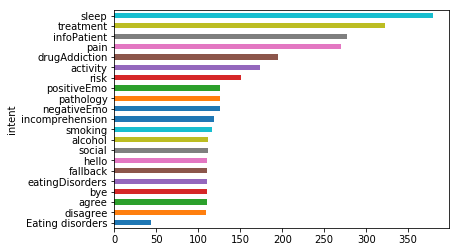

In [59]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

## Preprocess

### Tokenize the text

In [13]:
import nltk, re

In [14]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [15]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(data)

### Clean the text

In [16]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(data)

In [17]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(data)

In [18]:
from gensim.corpora import Dictionary

In [19]:
dictionary = Dictionary(documents=data.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 2058 words.


In [20]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(data)

In [21]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)

### Plot

In [22]:
from collections import Counter

In [23]:
import numpy as np

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax

In [25]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [26]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

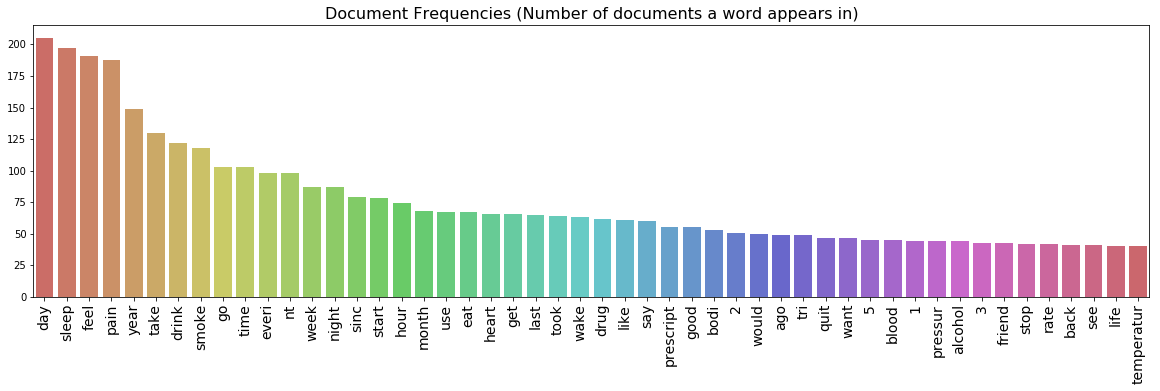

In [27]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

## W2V features

In [28]:
sentences = []
for sentence_group in data.text:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(data)))

Number of sentences: 107198.
Number of texts: 3307.


In [29]:
from gensim.models import Word2Vec

In [30]:
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

In [31]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    try:
        words = sentence_group  # words in text
    except:
        print(sentence_group)
        words = np.concatenate([['']])  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

data['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [32]:
data

,entities,intent,text,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow,w2v_features
0,"[{'start': 34, 'end': 38, 'value': 'wine', 'en...",alcohol,i’m drinking at least a bottle of wine a day i...,"[i, m, drinking, at, least, a, bottle, of, win...","[drinking, least, bottle, wine, day, week]","[drinking, least, bottle, wine, day, week]","[drink, least, bottl, wine, day, week]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]","[0.00013744396, -0.0001515547, -0.00039642394,..."
1,"[{'start': 8, 'end': 18, 'value': 'six ounces'...",alcohol,i drink six ounces of vodka average per day,"[i, drink, six, ounces, of, vodka, average, pe...","[drink, six, ounces, vodka, average, per, day]","[drink, six, ounce, vodka, average, per, day]","[drink, six, ounc, vodka, averag, per, day]","[(1, 1), (2, 1), (6, 1), (7, 1), (8, 1), (9, 1...","[0.000121832694, 0.00015642359, -0.0005331763,..."
2,"[{'start': 9, 'end': 19, 'value': 'for months'...",alcohol,i can go for months and at least a year or so ...,"[i, can, go, for, months, and, at, least, a, y...","[go, months, least, year, without, drinking]","[go, month, least, year, without, drinking]","[go, month, least, year, without, drink]","[(2, 1), (3, 1), (11, 1), (12, 1), (13, 1), (1...","[0.00017814872, -0.00010592949, -0.0008873735,..."
3,[],alcohol,i'm in end stage of alcohol addiction,"[i, m, in, end, stage, of, alcohol, addiction]","[end, stage, alcohol, addiction]","[end, stage, alcohol, addiction]","[end, stage, alcohol, addict]","[(15, 1), (16, 1), (17, 1), (18, 1)]","[0.00045316748, -0.00012383416, -0.00047462343..."
4,"[{'start': 11, 'end': 20, 'value': 'four pack'...",alcohol,i do buy a four pack every night after work,"[i, do, buy, a, four, pack, every, night, afte...","[buy, four, pack, every, night, work]","[buy, four, pack, every, night, work]","[buy, four, pack, everi, night, work]","[(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), ...","[-0.000118559496, -3.2687563e-05, -0.000792799..."
5,[],alcohol,i am trying to stop drinking,"[i, am, trying, to, stop, drinking]","[trying, stop, drinking]","[trying, stop, drinking]","[tri, stop, drink]","[(2, 1), (25, 1), (26, 1)]","[0.00044002736, -0.00028981644, -0.00066520943..."
6,"[{'start': 53, 'end': 73, 'value': 'for the pa...",alcohol,i’m 25 years old and i’ve been battling with a...,"[i, m, 25, years, old, and, i, ve, been, battl...","[25, years, old, battling, alcohol, past, 5, y...","[25, year, old, battling, alcohol, past, 5, year]","[25, year, old, battl, alcohol, past, 5, year]","[(14, 2), (16, 1), (27, 1), (28, 1), (29, 1), ...","[-0.0002216162, -0.0002796735, -0.0005811784, ..."
7,[],alcohol,i don’t drink often but when i do drink i don’...,"[i, don, t, drink, often, but, when, i, do, dr...","[drink, often, drink, know, limits]","[drink, often, drink, know, limit]","[drink, often, drink, know, limit]","[(2, 2), (32, 1), (33, 1), (34, 1)]","[5.4208092e-05, -0.00015779318, -0.00048477727..."
8,[],alcohol,"weekends it all goes out of the window though,...","[weekends, it, all, goes, out, of, the, window...","[weekends, goes, window, though, drink, much]","[weekend, go, window, though, drink, much]","[weekend, go, window, though, drink, much]","[(2, 1), (11, 1), (35, 1), (36, 1), (37, 1), (...","[-0.00012857582, -0.0003221071, -0.00047449107..."
9,[],alcohol,i’m now 2 months clean back home,"[i, m, now, 2, months, clean, back, home]","[2, months, clean, back, home]","[2, month, clean, back, home]","[2, month, clean, back, home]","[(12, 1), (39, 1), (40, 1), (41, 1), (42, 1)]","[-0.00024029738, -7.171369e-05, -0.0007385729,..."


## Pretrained embeddings

In [2]:
import gensim.downloader as api

In [3]:
info = api.info()

In [4]:
model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
model = api.load("word2vec-google-news-300")

### test

In [6]:
model.most_similar("sleep")

[('wake', 0.9654639959335327),
 ('tired', 0.9245999455451965),
 ('feel', 0.9237402081489563),
 ('awake', 0.9227220416069031),
 ('sleeping', 0.9174003601074219),
 ('alone', 0.9170509576797485),
 ('too', 0.9083741307258606),
 ('asleep', 0.9069899320602417),
 ('sigh', 0.9062435030937195),
 ('ill', 0.9025631546974182)]

In [54]:
data['glove_features'] = list(map(lambda sen_group:
                                      get_w2v_features(model, sen_group),
                                      data.text))

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', 
                                                        binary=True) 

In [ ]:
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

## LDA features

In [33]:
from gensim.models import LdaModel, LdaMulticore

In [34]:
corpus = data.bow

In [35]:
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [36]:
LDAmodel.top_topics(corpus=corpus)[5]

([(0.15694158, 'bodi'),
  (0.1235107, 'temperatur'),
  (0.073111355, '67'),
  (0.06291737, 'gone'),
  (0.046942495, 'hour'),
  (0.042191237, 'feel'),
  (0.031037856, 'start'),
  (0.02279845, 'everi'),
  (0.022521721, 'day'),
  (0.022239413, 'usual'),
  (0.021833949, 'consolid'),
  (0.021833949, 'block'),
  (0.021833947, 'vodka'),
  (0.021833947, 'drink'),
  (0.021833947, '3pm'),
  (0.021833947, '11pm'),
  (0.021827733, 'fahrenheit'),
  (0.019383606, 'degre'),
  (0.012136974, 'around'),
  (0.01143334, 'averag')],
 -13.358610011976113)

In [37]:
def document_to_lda_features(lda_model, document):
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      data.bow))

## HDP modeling

In [38]:
from gensim.models import HdpModel

In [ ]:
list(filter(lambda x: len(x) > 0, corpus))

In [148]:
hdp = HdpModel(corpus=list(filter(lambda x: len(x) > 0, corpus)), id2word=dictionary)

In [155]:
hdp.print_topics()

[(0,
  '0.003*ritonavir + 0.003*infect + 0.003*amikacin + 0.003*ach + 0.003*climb + 0.003*94 + 0.003*rigor + 0.003*wheelchair + 0.003*heat + 0.003*group'),
 (1,
  '0.003*19 + 0.003*patch + 0.003*moral + 0.003*whilst + 0.003*today + 0.003*cant + 0.003*desper + 0.002*affirm + 0.002*deeper + 0.002*special'),
 (2,
  '0.004*suboxon + 0.003*tall + 0.003*coricidin + 0.003*aaaaaaazz + 0.003*120mg + 0.003*learn + 0.003*exerciseinduc + 0.003*hydroxychloroqin + 0.003*pessimist + 0.003*shut'),
 (3,
  '0.004*190 + 0.004*bloodi + 0.003*80 + 0.003*cee + 0.003*rest + 0.003*switch + 0.003*39 + 0.003*middlenam + 0.003*hope + 0.003*sunday'),
 (4,
  '0.005*diagnosi + 0.004*98976f + 0.004*system + 0.004*old + 0.003*fatigu + 0.003*use + 0.003*chain + 0.003*half + 0.003*swallow + 0.003*decid'),
 (5,
  '0.005*coricidin + 0.004*start + 0.003*diet + 0.003*squeez + 0.003*10325 + 0.003*fiber + 0.003*day + 0.003*jog + 0.003*coke + 0.003*remicad'),
 (6,
  '0.004*tender + 0.003*done + 0.003*swollen + 0.003*cefalexin

kind of mess

## Dataset

In [47]:
X_train_lda = np.array(list(map(np.array, data.lda_features)))
X_train_w2v = np.array(list(map(np.array, data.w2v_features)))
#X_train_glove = np.array(list(map(np.array, data.glove_features)))
#X_train_combined = np.append(
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)
#, X_train_glove, axis=1)

In [40]:
X_train_combined.shape

(3307, 350)

## Clustering

In [48]:
from sklearn.cluster import KMeans

In [60]:
km = KMeans(5).fit(X_train_lda)

In [61]:
comp = pd.DataFrame(data[['text', 'intent']])

In [62]:
comp['clusters'] = km.predict(X_train_lda)

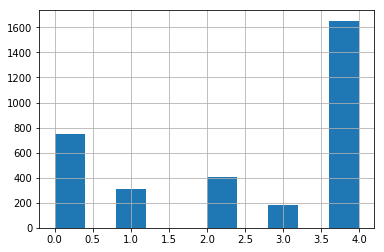

In [63]:
comp['clusters'].hist()

In [64]:
pd.pivot_table(comp, index='intent', columns='clusters', aggfunc=len, fill_value=0)\
            .style.background_gradient(axis=1)

In [90]:
comp[comp['clusters']==0]['text'].unique()

array(['i do buy a four pack every night after work',
       'when i was drinking vodka came 1st 2nd 3rd',
       "when i say drinking it's either four cans or half a bottle of wine each week evening",
       'if i dont drink for a day or two, i feel fine in myself',
       "i'm a drunk", 'i had two attemps at reducing my drinking',
       'i have a love of alcohol', 'i am a true drinker',
       'i usually start drinking at 3pm every day and by 11pm the vodka is gone',
       'i am a functioning alcoholic',
       'i was anorexic and bulimic during my 20 up to my 40',
       'i am in the process of tapering from suboxone long-term use',
       'i have been back and forth with suboxone',
       "i've been giving myself straight dopamine for over a year and abruptly stopped",
       'i am in the process of getting off of tramadol',
       'i am suppose to be nicotine free for 2-3 months',
       'just been on the patch for 4 days', 'i really do love smoking',
       'i’ve not had a ciga

## Quick easy classifier

In [84]:
from sklearn.svm import SVC

In [85]:
clf = SVC().fit(X_train_combined, data['intent'])

/home/alice/Mines/paradec/paradec/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [86]:
clf.score(X_train_combined, data['intent'])

0.1149077713940127

In [91]:
clf.predict(X_train_combined[:40])

array(['sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep',
       'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep',
       'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep',
       'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep',
       'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep', 'sleep',
       'sleep', 'sleep', 'sleep', 'sleep', 'sleep'], dtype=object)

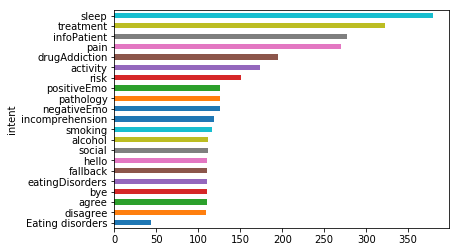

In [110]:
data.groupby('intent').count()['text'].sort_values().plot(kind='barh')

sentences embeddings

1. biLSTM
2. CNN
3. Emlo

different clustering models  as evaluation

purity + metrics

classification on obrained features

one-shot